# EDA

Importing libraries

In [ ]:
import sys
import os
import sqlite3
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))

import utils.text_processing as tp

In [24]:
#Getting de database
connection = sqlite3.connect('../data/raw/pubmed_data.db')
df = pd.read_sql_query("SELECT * FROM pubmed_data", connection)
connection.close()

In [ ]:
#Cleaning text
df['cleaned_abstract'] = df['abstract'].apply(tp.clean_text)

print(df['cleaned_abstract'].head())
print(len(df))

0    recurrent highgrade intracranial malignancy gr...
1    purpose smallcell lung cancer sclc account app...
2    background androgenic alopecia aga commonly kn...
3    background neoadjuvant chemotherapy may consid...
4    background cicatricial alopecias chronic progr...
Name: cleaned_abstract, dtype: object
1000


In [26]:
df = df[df['cleaned_abstract'].str.strip() != '']
print(f'Total abstracts after removing empty ones: {len(df)}')

Total abstracts after removing empty ones: 970


In [ ]:
keywords = ['androgenetic alopecia','alopecia', 'hair loss', 'baldness']

def is_relevant(text):
    return any(keyword in text.lower() for keyword in keywords)

df = df[df['cleaned_abstract'].apply(is_relevant)]
print

<function print>

Since we have no labeled data I will take a non-supervised approach and make semantic clustering of the data.

In [ ]:
df['BERT_embeddings'] = df['cleaned_abstract'].apply(tp.get_bert_embeddings)

## Making semantic clustering

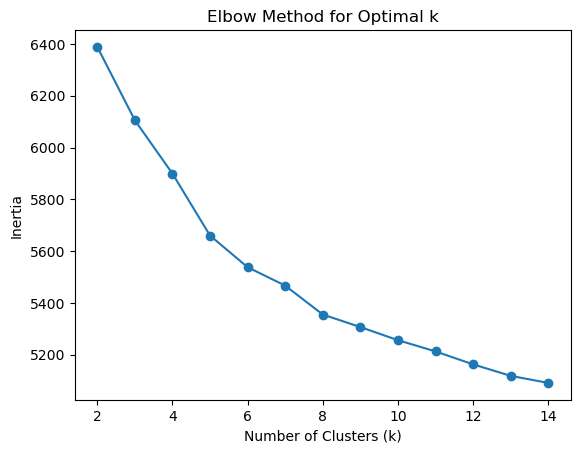

In [32]:
embeddings = df['BERT_embeddings'].tolist()

#Using elbow method to find optimal number of clusters
inertia = []
k_values = range(2,15)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)
    
#Visualization
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings)

df['Clusters'] = clusters

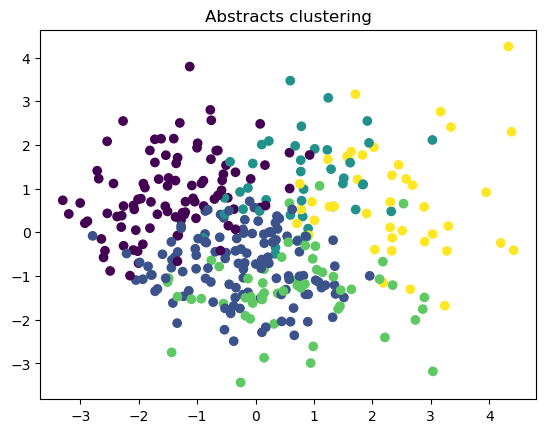

In [35]:
#Visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
plt.title('Abstracts clustering')
plt.show()

In [37]:
#Cluster interpretation
for cluster_id in range(kmeans.n_clusters):
    print(f"Cluster {cluster_id} Examples:")
    print(df[df['Clusters'] == cluster_id]['cleaned_abstract'].head(6).values)
    print('-'*80)

Cluster 0 Examples:
['background cicatricial alopecias chronic progressive scar hairloss condition molecular dysregulation fully understand hinder treatment development thifngamma signal jak dysregulation show involvement provide rationale phase trial tykjak inhibitor brepocitinib method randomize placebocontrolle phase trial span week adult year age lichen planopilaris frontal fibrose alopecia central centrifugal cicatricial alopecia diagnosis randomize brepocitinib daily placebo week patient receive brepocitinib another week safety follow week later lesional scalp biopsy collect baseline week week coprimary endpoint change lesional expression ccl change lesional expression fibrosisrelate marker safety week result patient receive brepocitinib show significant downregulation ccl expression week enrichment analysis subset fibrosis marker show trend upregulation placebo patient brepocitinib well tolerate improve clinical severity score limitation singledose regimen small placebo group co

In [39]:
#Delete irrelevant clusters.
irrelevant_clusters = [4]
df = df[~df['Clusters'].isin(irrelevant_clusters)]

In order to tag the clusters we are going to make a thematic analysis of the clusters.

In [ ]:
for cluster_id in df['Clusters'].unique():
    cluster_texts =df[df['Clusters'] == cluster_id]['cleaned_abstract']
    print(f'\nCluster {cluster_id} - Top Words:')
    print(Counter(" ".join(cluster_texts).split()).most_common(10))